In [1]:
import os
from typing import List, Tuple

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from utils.MovingAverager import *

In [2]:
def exp_filter(data):
    x=0.5  # smoothening factor
  
    i = 1
    # Initialize an empty list to
    # store exponential moving averages
    moving_averages = []

    # Insert first exponential average in the list
    moving_averages.append(data[0])

    # Loop through the array elements
    while i < len(data):

        # Calculate the exponential
        # average by using the formula
        window_average = round((x*data[i])+
                               (1-x)*moving_averages[-1], 2)

        # Store the cumulative average
        # of current window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1
        
    return np.array(moving_averages)

In [3]:
def cal_error(data1: np.array, data2: np.array):
    return np.sum(np.power(data1 - data2, 2), axis=-1)

def align_error(search_data: np.array, whole_data: np.array):
    ncols = len(search_data)
    nrows = len(whole_data) - len(search_data) + 1
    
    index = np.zeros((nrows, ncols), dtype=int)
    index += np.arange(ncols)
    index += np.arange(nrows).T[:, None]
    
    total_error = cal_error(search_data, whole_data[index])
    return total_error

In [9]:
def gen_df(data_loc: str):
    df = pd.read_csv(data_loc, delimiter=';')
    df.columns = ['mag_times', 'mag_x', 'mag_y', 'mag_z']
    
    df['mag_x'] = moving_average(df['mag_x'], 41)
    df['mag_y'] = moving_average(df['mag_y'], 41)
    df['mag_z'] = moving_average(df['mag_z'], 41)
    
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))

#     df['mag_t'] = exp_filter(df['mag_t'].to_numpy())
#     df['mag_t'] = moving_average(df['mag_t'], 71)
    
    return df

def get_data(folder: str):
    
    source_loc = folder + '/source/Magnetometer.csv'
    target_loc = folder + '/target/Magnetometer.csv'
    
    return gen_df(source_loc), gen_df(target_loc)

def plot_cruve(source: pd.DataFrame, target: pd.DataFrame, x=15, y=15, title=None):
    plt.figure(figsize=(x, y))
    plt.suptitle(title)
    plt.plot(source.index, source['mag_t'])
    plt.plot(target.index, target['mag_t'])
    plt.show()

def plot_align(source: pd.DataFrame, target: pd.DataFrame, index: Tuple, x=15, y=5):
    error = align_error(source.loc[index[0]:index[1], 'mag_t'].to_numpy(), target['mag_t'].to_numpy())
    min_index = np.argmin(error)
    length = index[1] - index[0]
    
    plt.figure(figsize=(x, y))
    
    ####################
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(index[0], index[1]), source['mag_t'][index[0]:index[1]], color='pink', alpha=0.9, linewidth=10, label='search segment')
    plt.plot(np.arange(min_index, min_index + length), target['mag_t'][min_index:min_index + length], color='green', alpha=0.4, linewidth=10, label='compare result')
    plt.plot(source.index, source['mag_t'], label='source')
    plt.plot(target.index, target['mag_t'], label='target')
    
    plt.legend()
    
    ####################
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(error)), error)
    
    plt.scatter(index[0], error[index[0]], c='purple', s=50, label=f'gt index: {index[0]}')
    plt.scatter(min_index, error[min_index], c='red', s=50, label=f'compare index: {min_index}')
    
    plt.legend()
    plt.show()

def check(folder: str, x: int = 15, y: int = 5, window_size: int = 500):
    
    source, target = get_data(folder)
    plot_cruve(source, target, x, y, title=f'{folder}')

    for i in range(500, len(source) - window_size, 500):
        plot_align(source, target, (i, i + window_size), x, y)

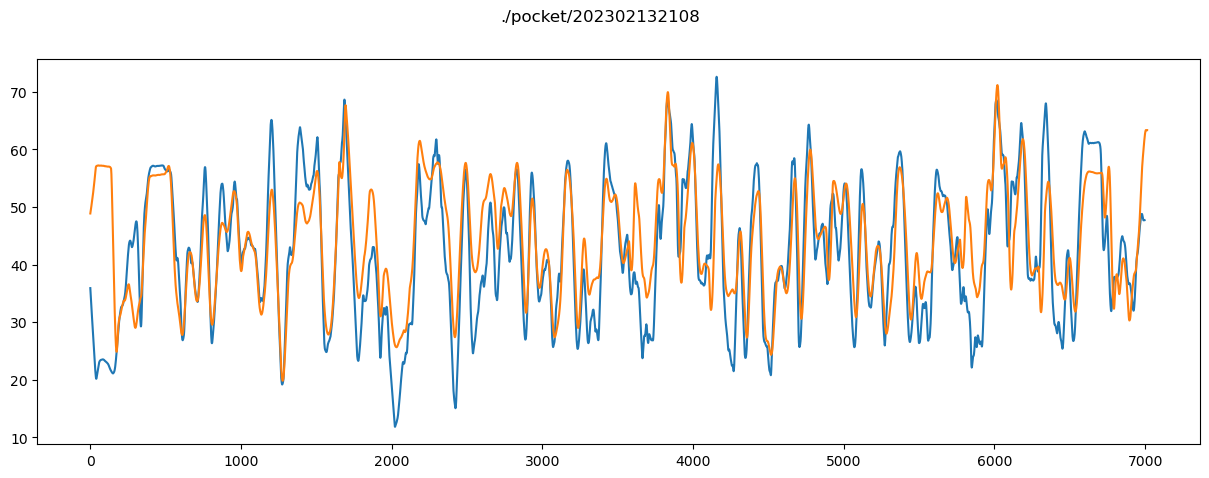

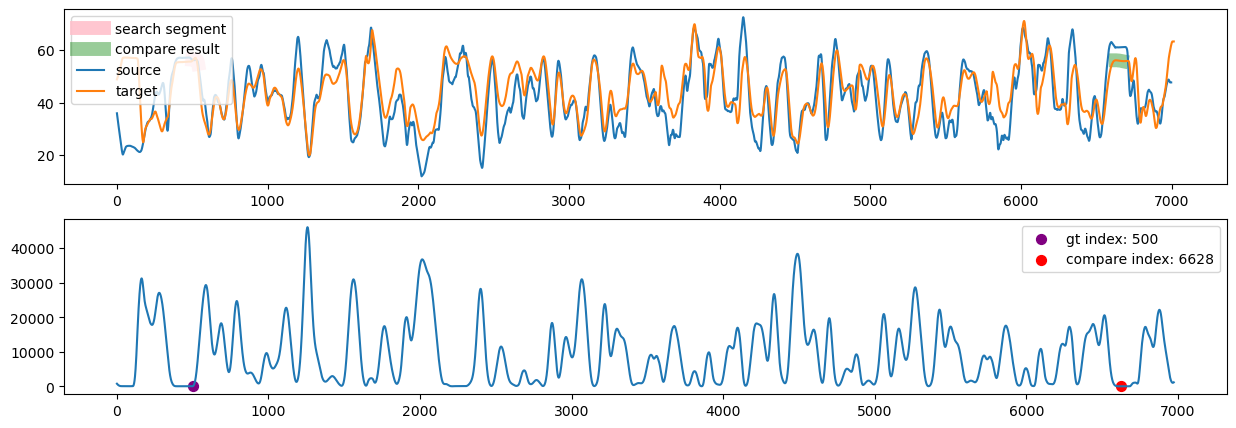

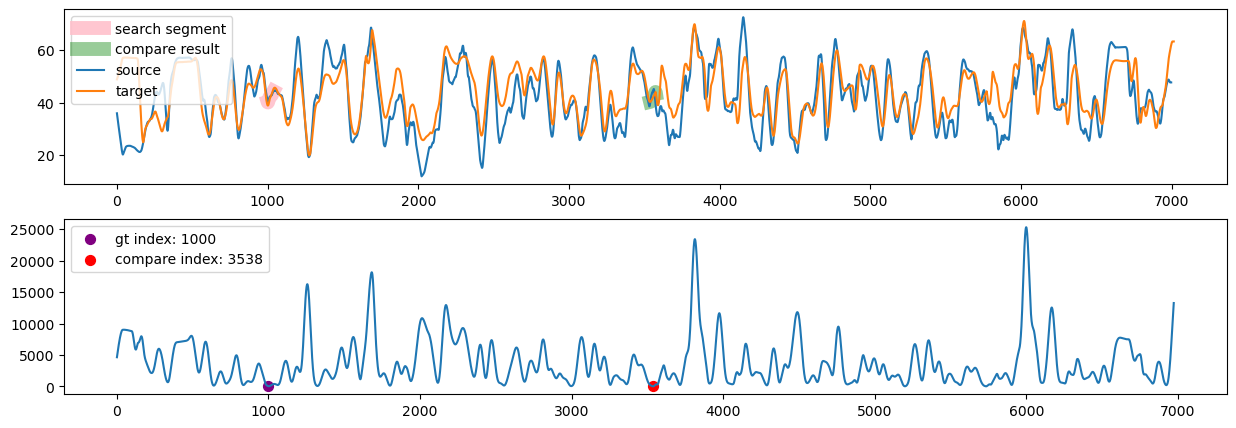

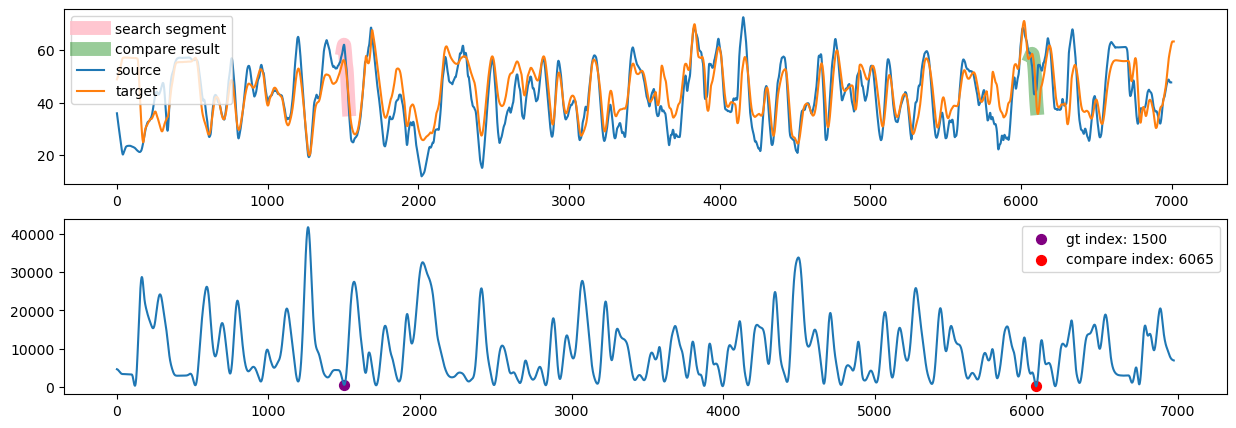

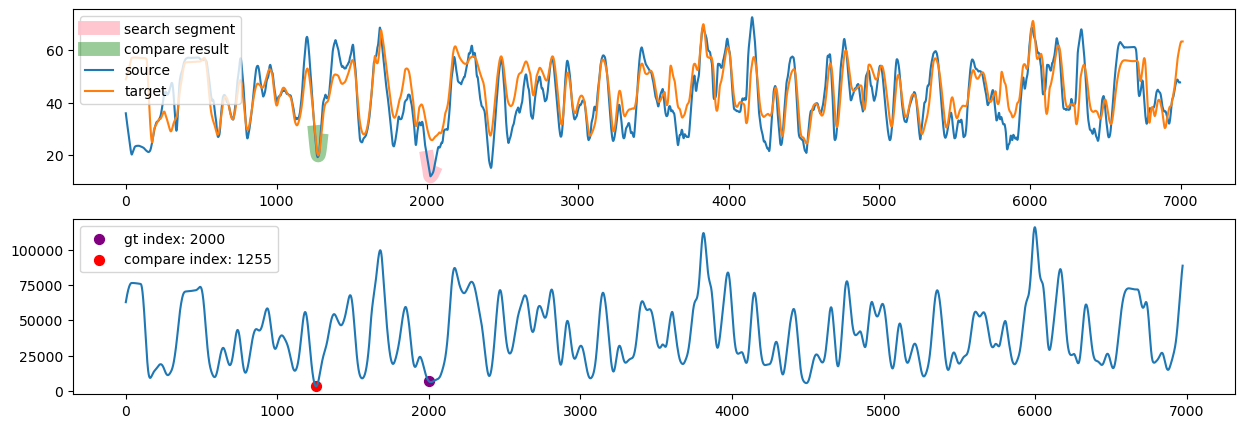

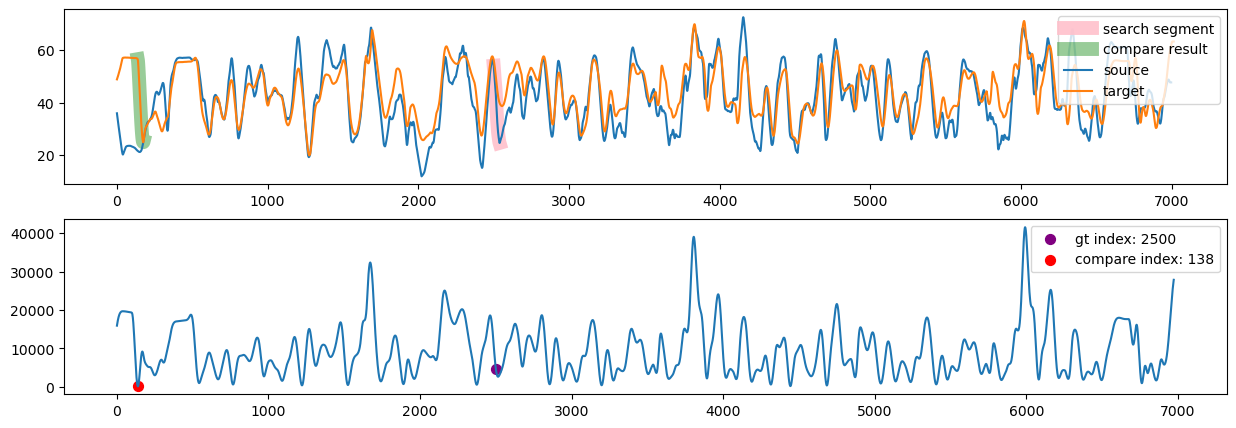

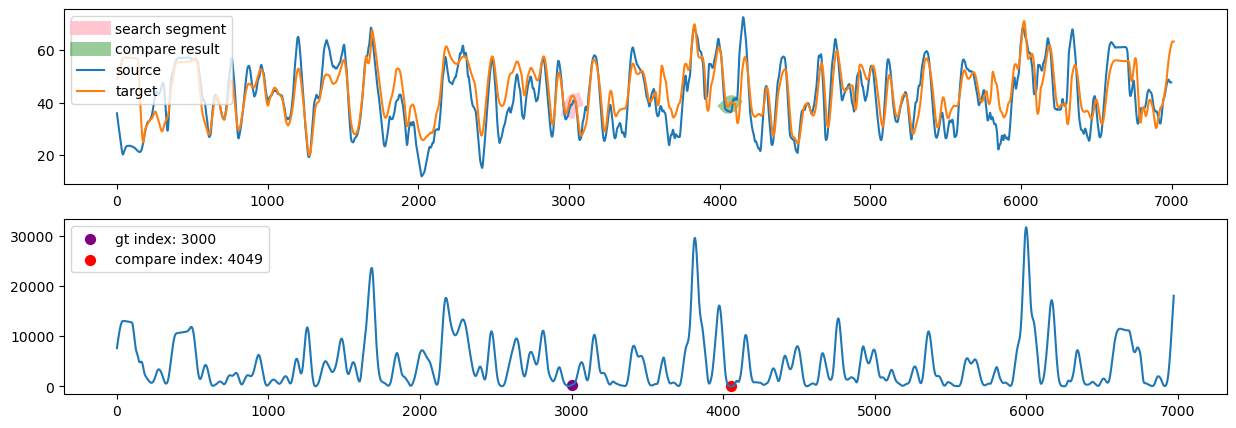

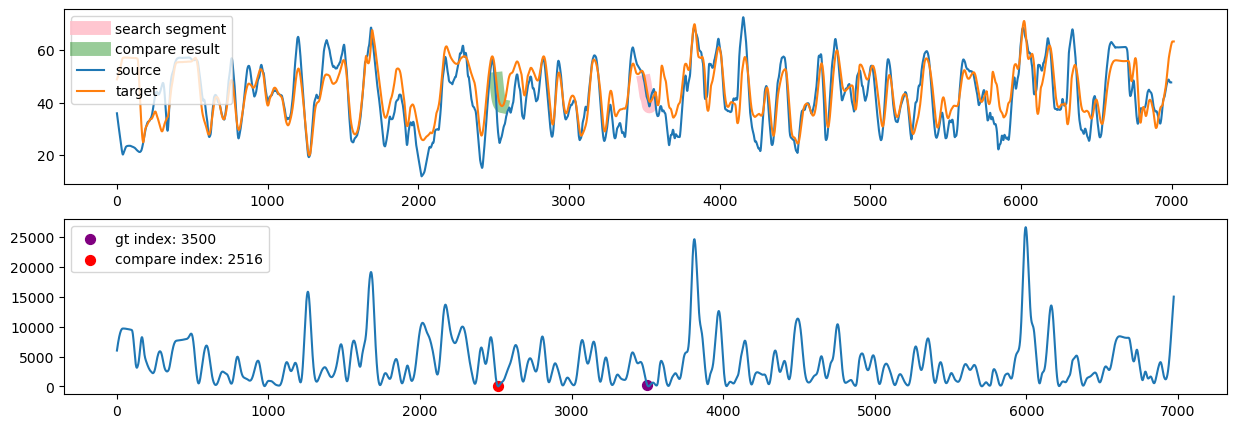

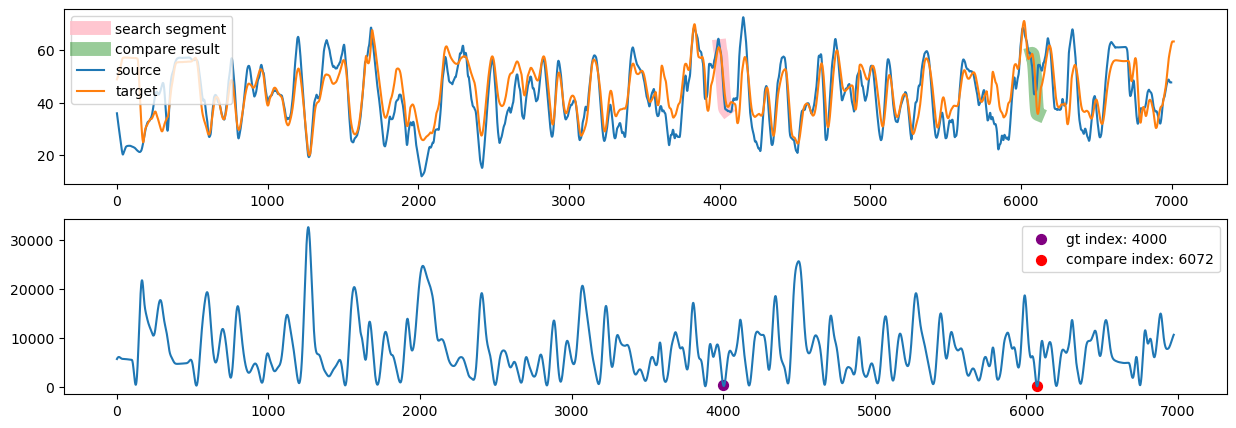

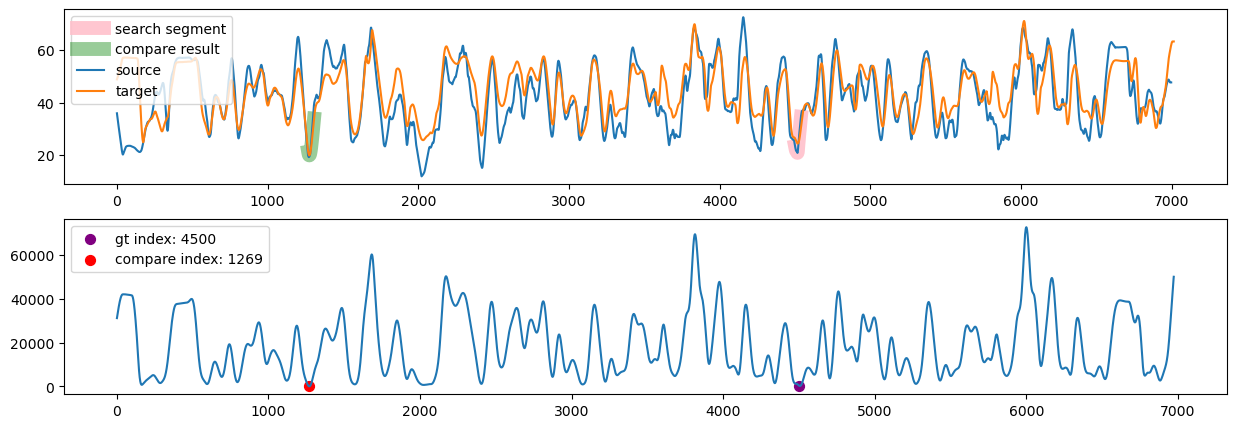

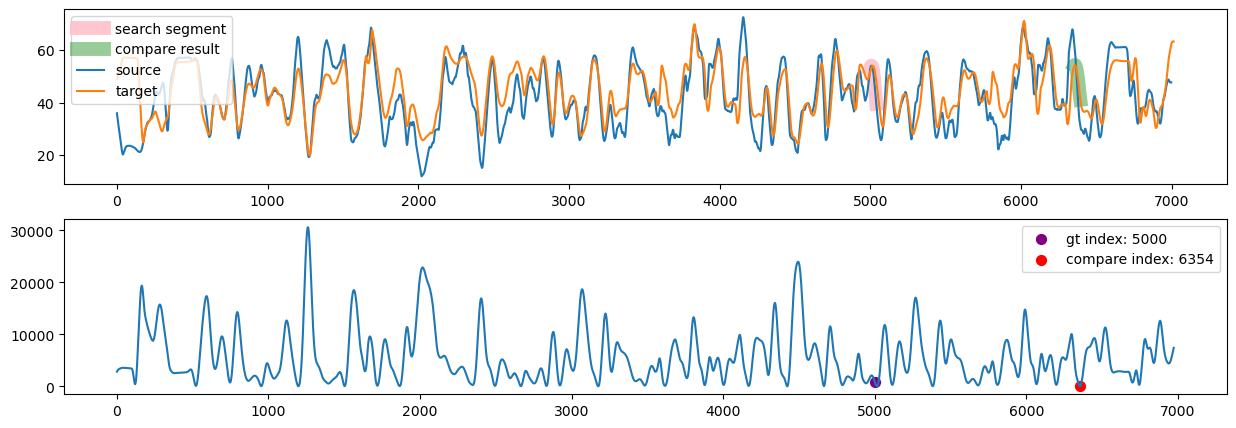

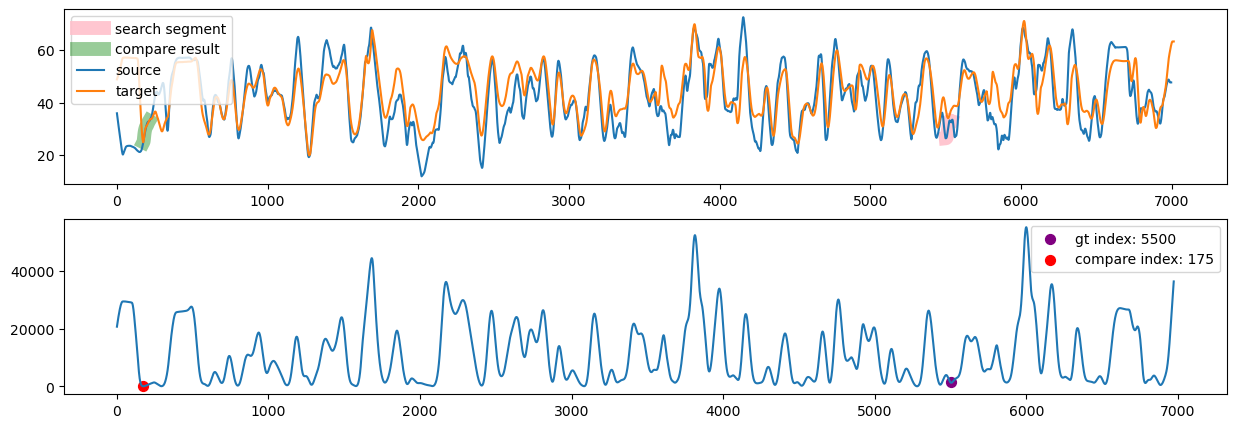

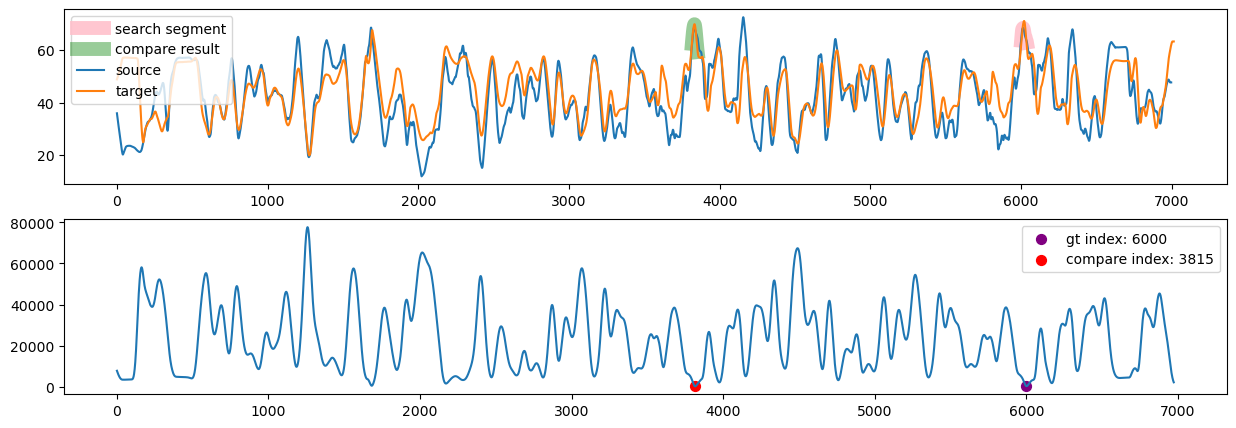

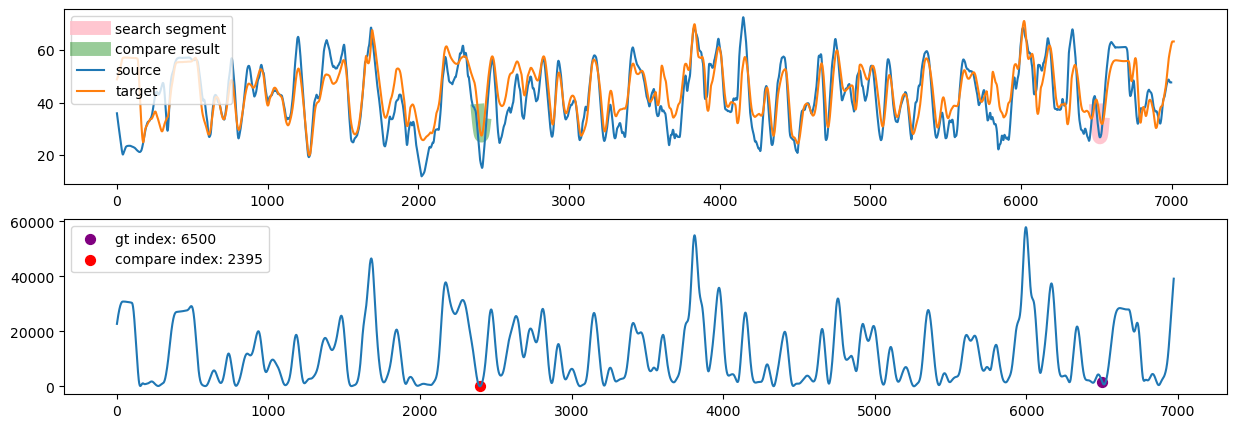

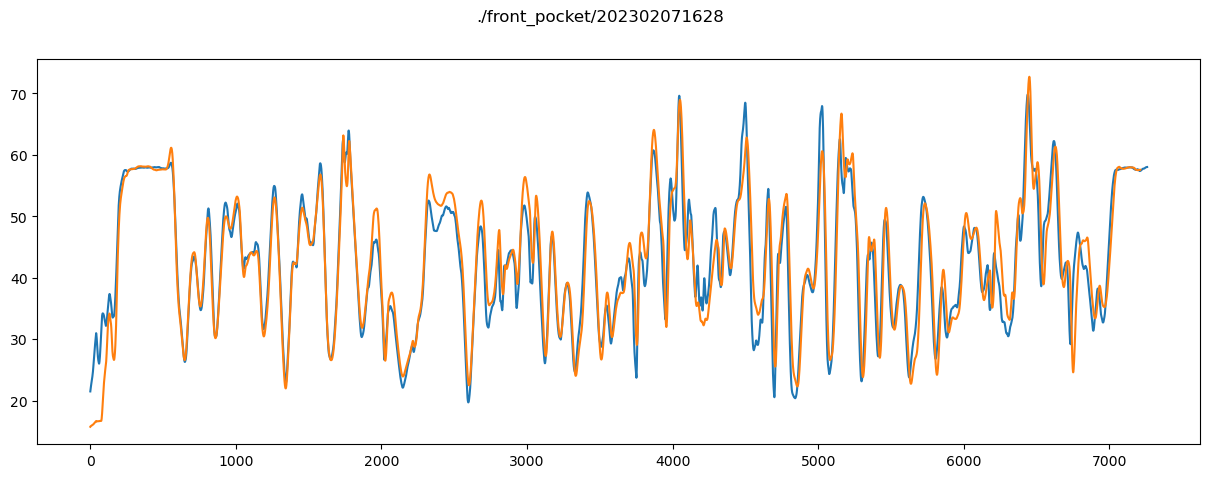

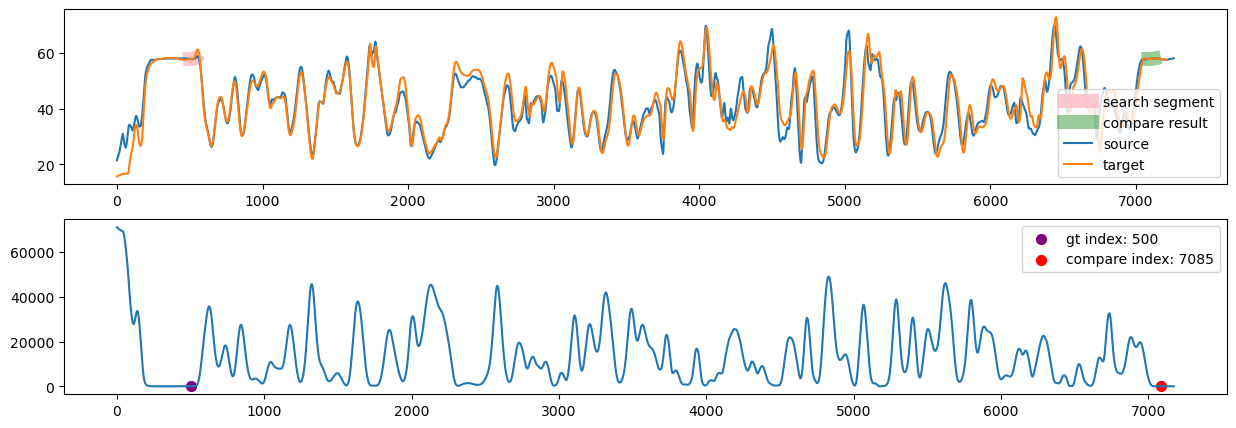

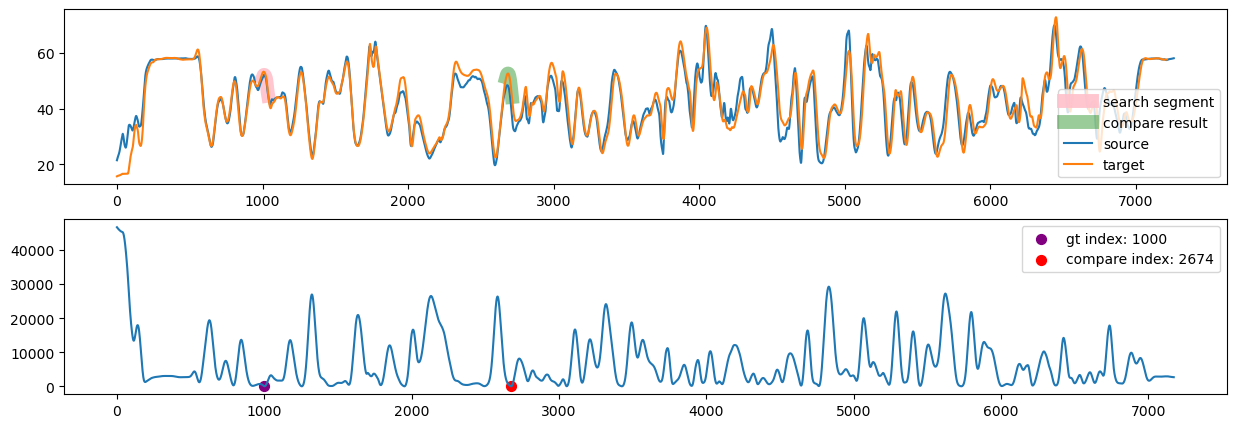

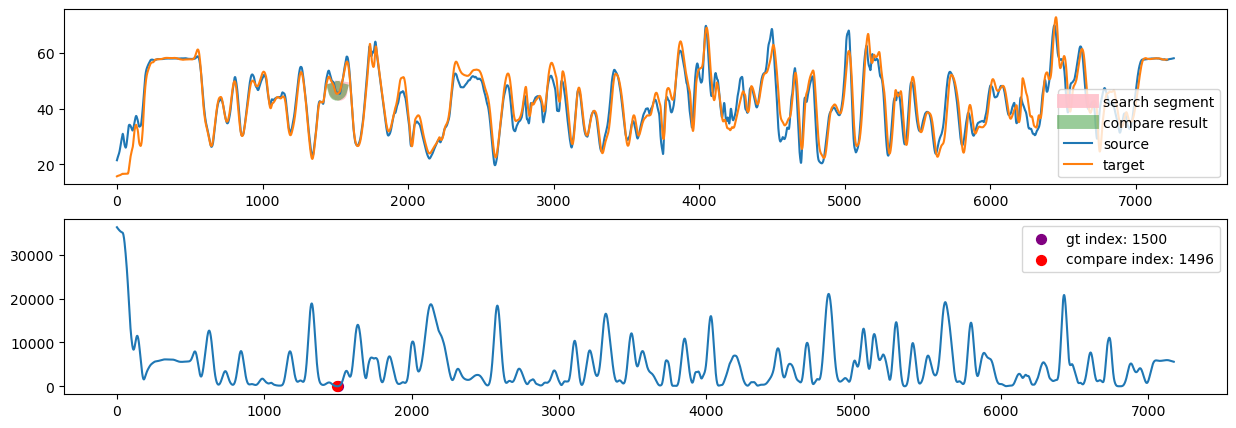

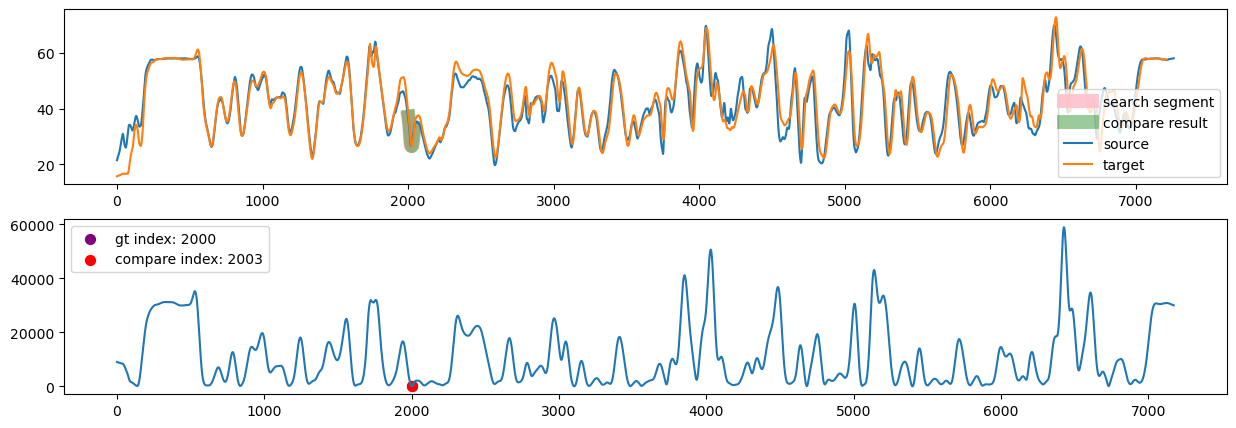

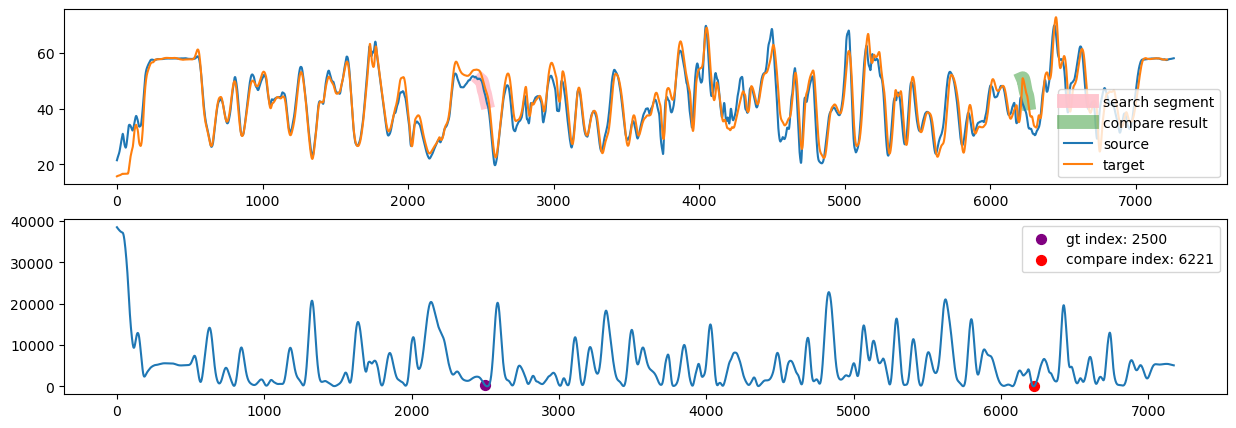

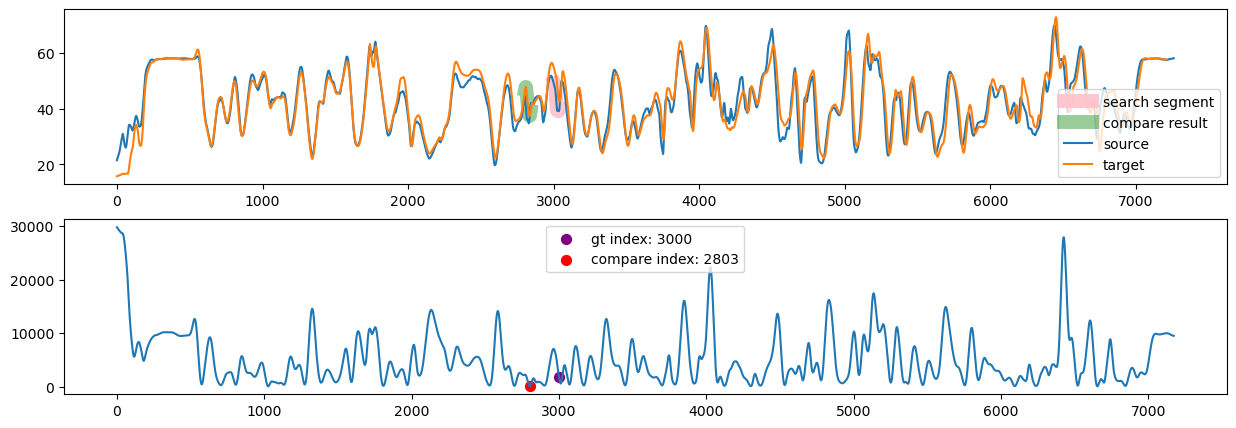

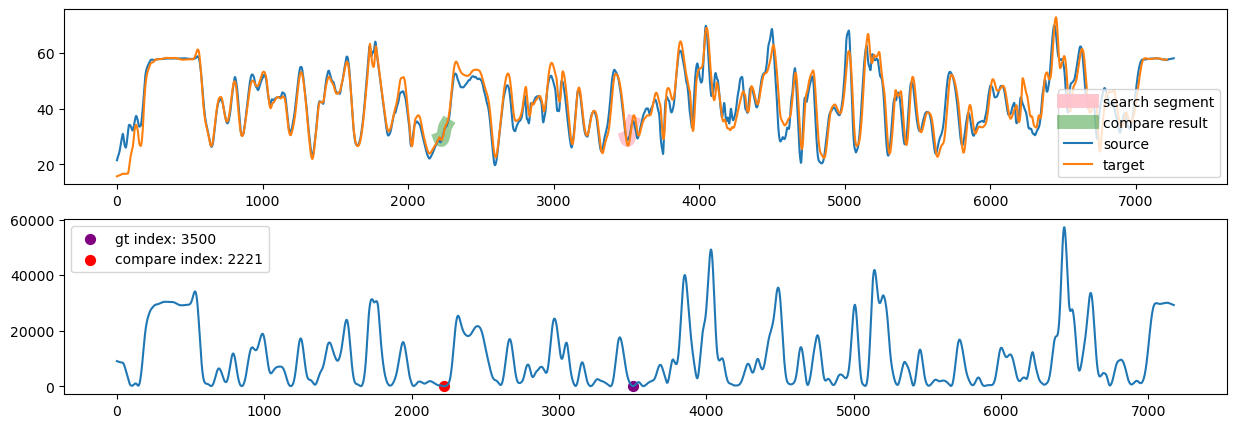

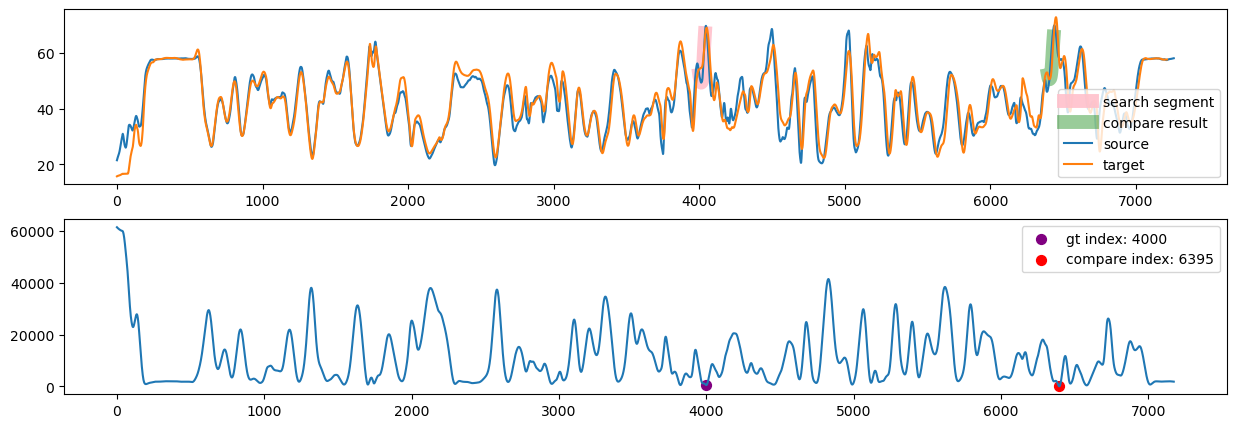

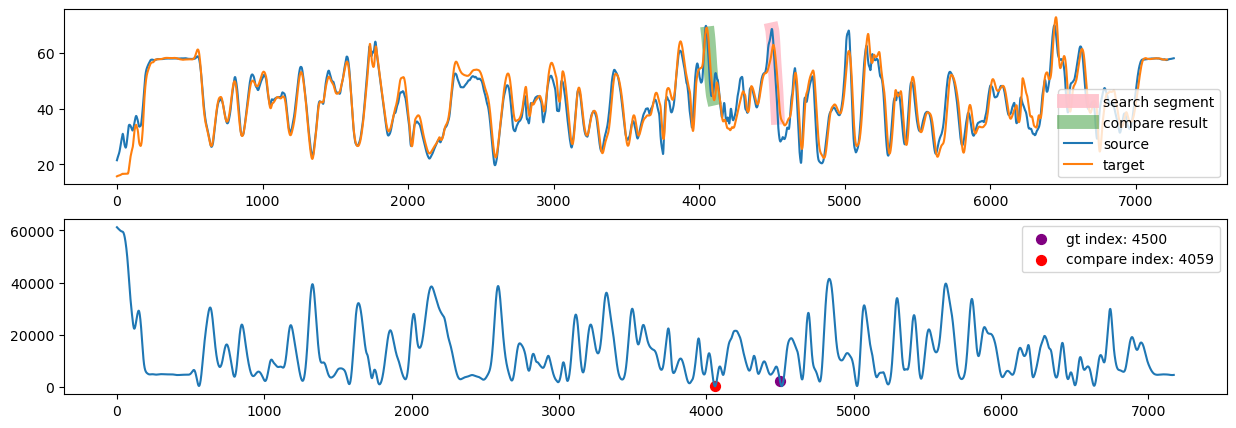

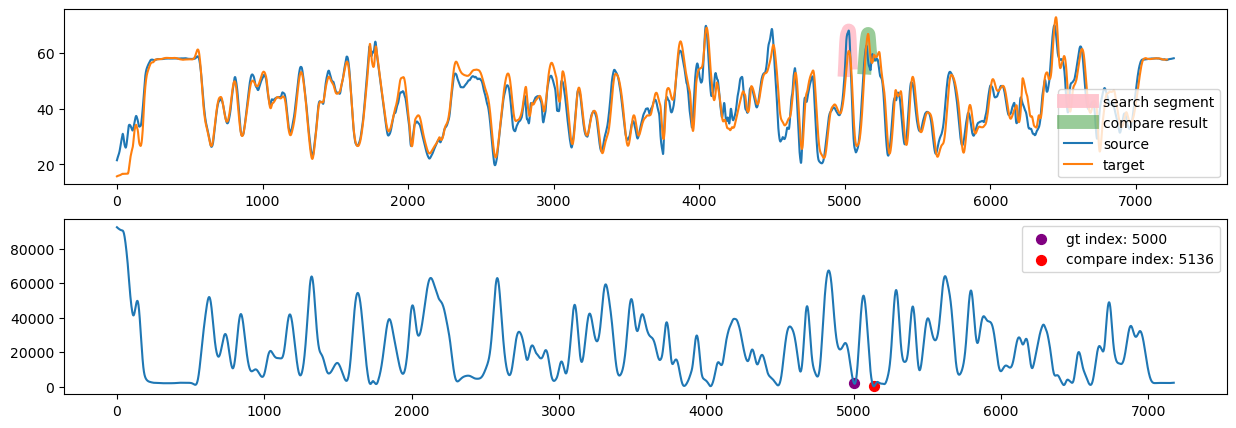

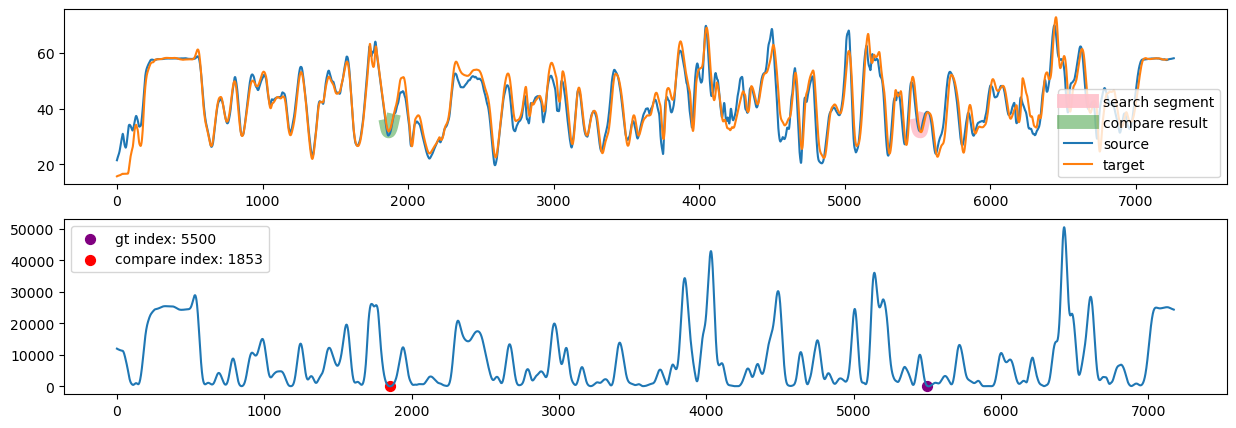

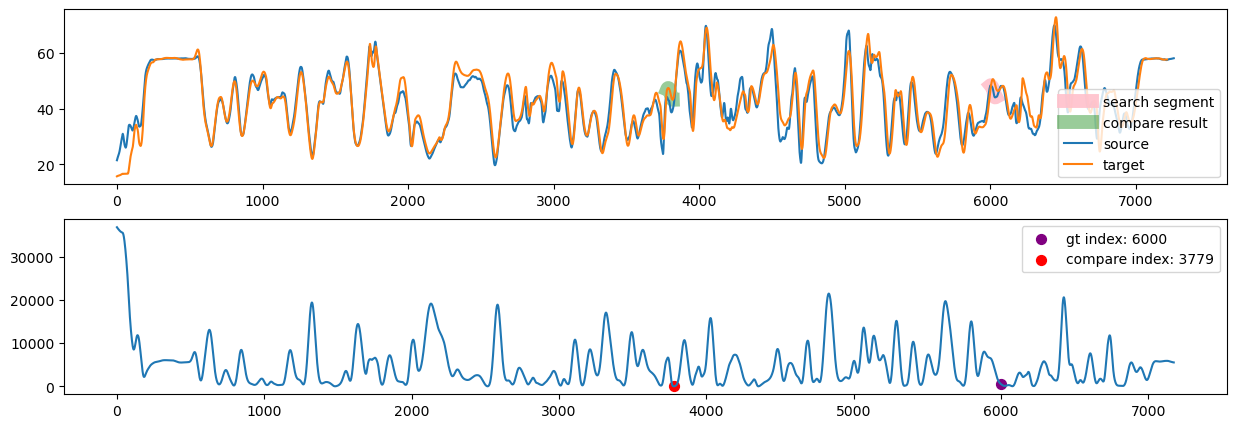

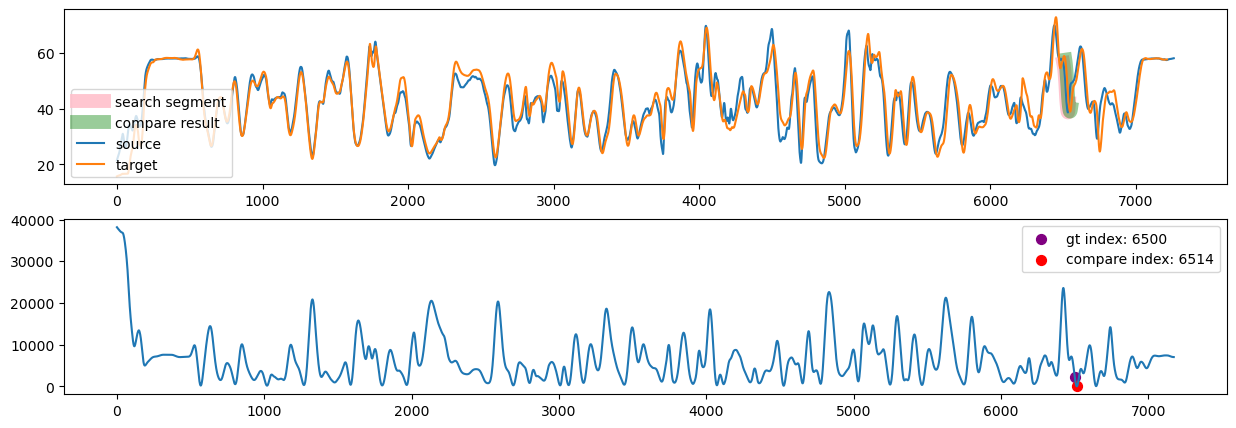

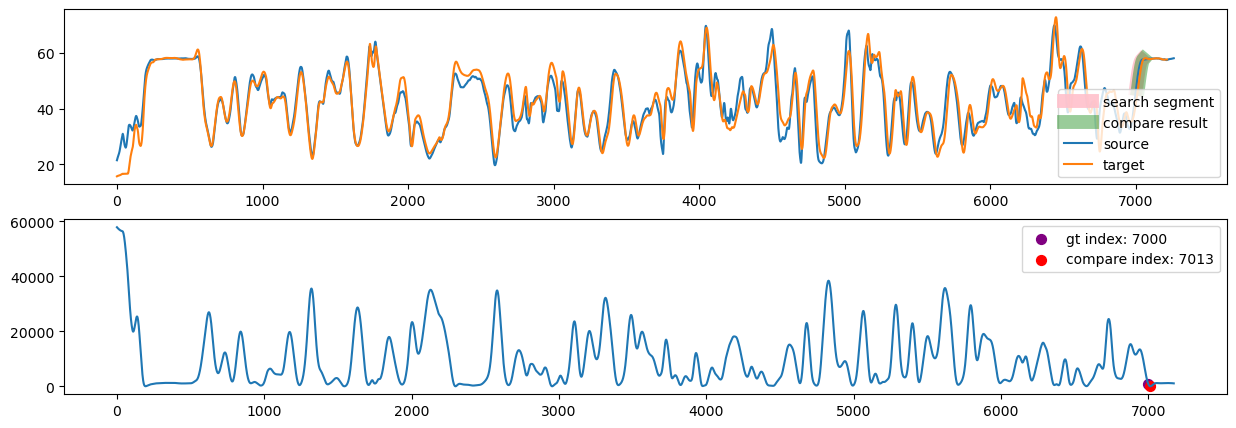

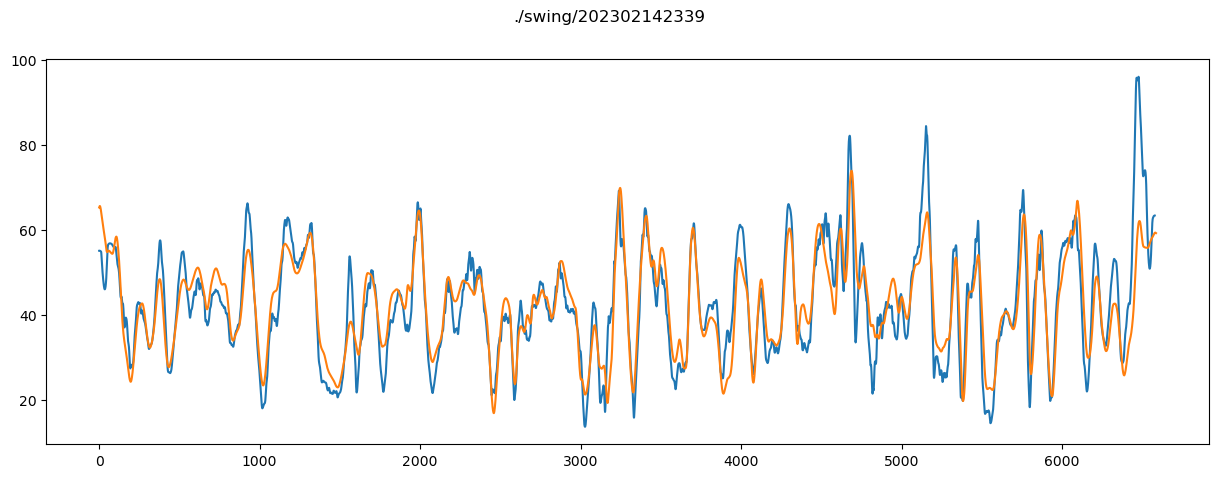

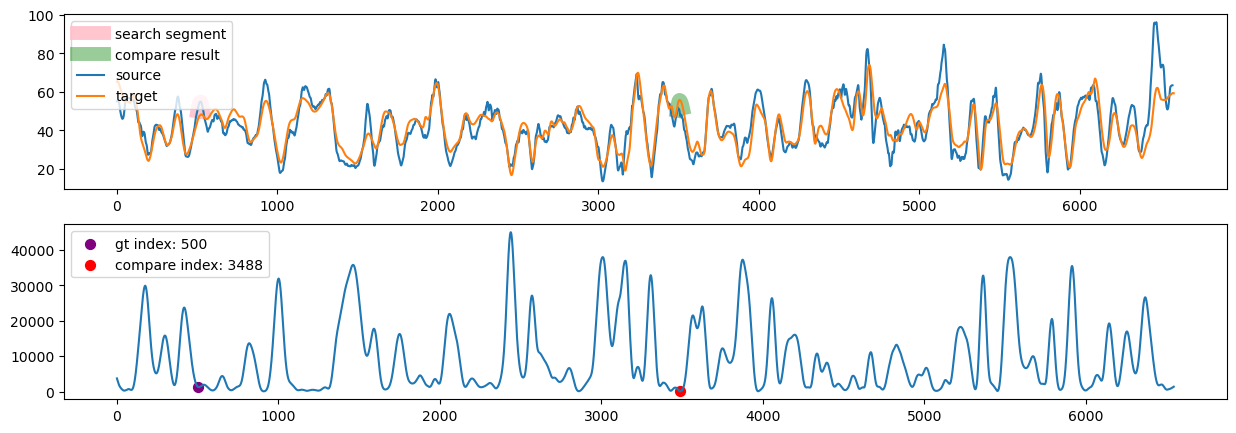

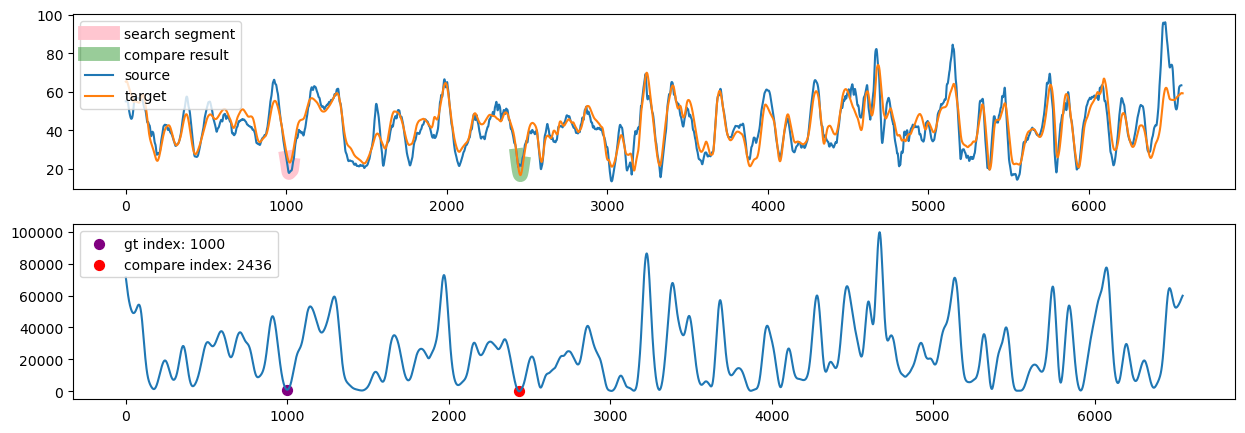

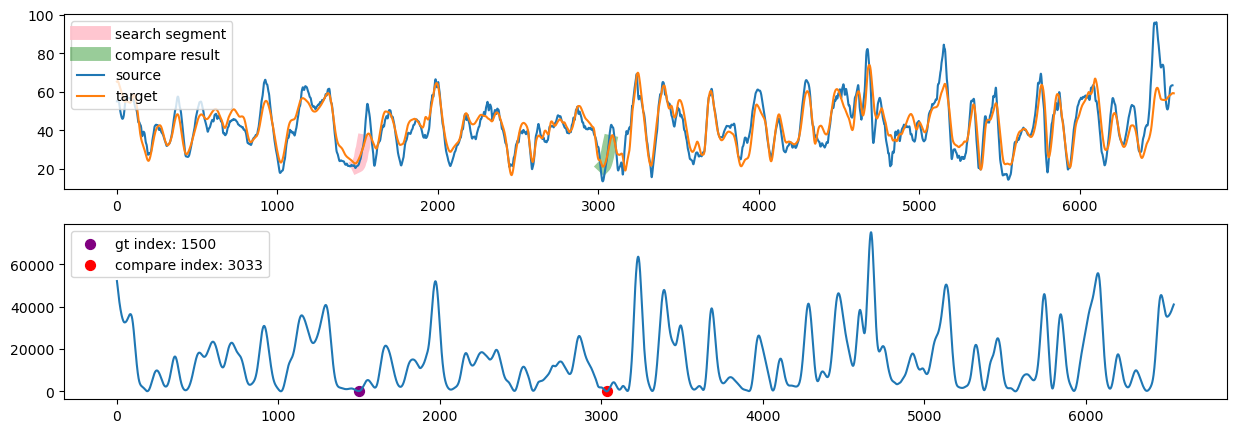

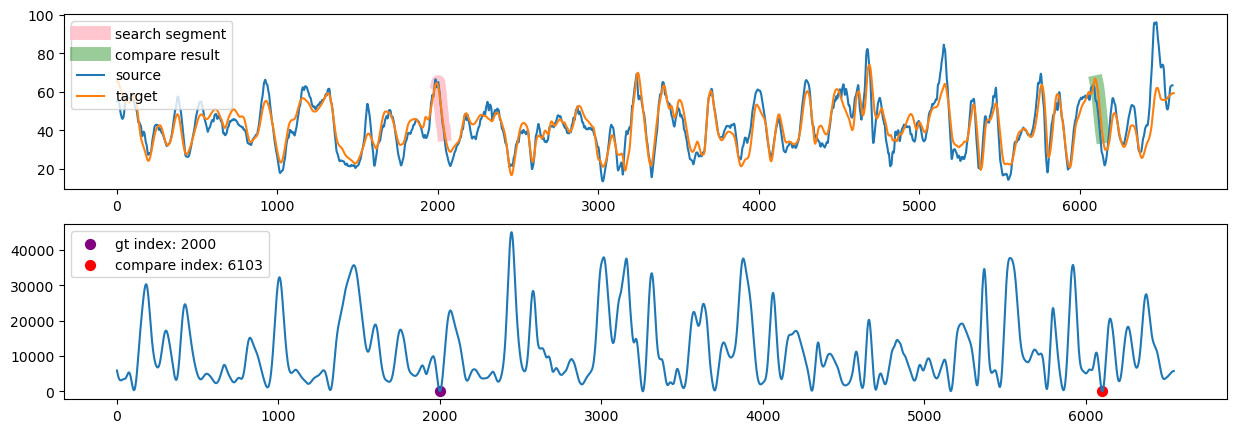

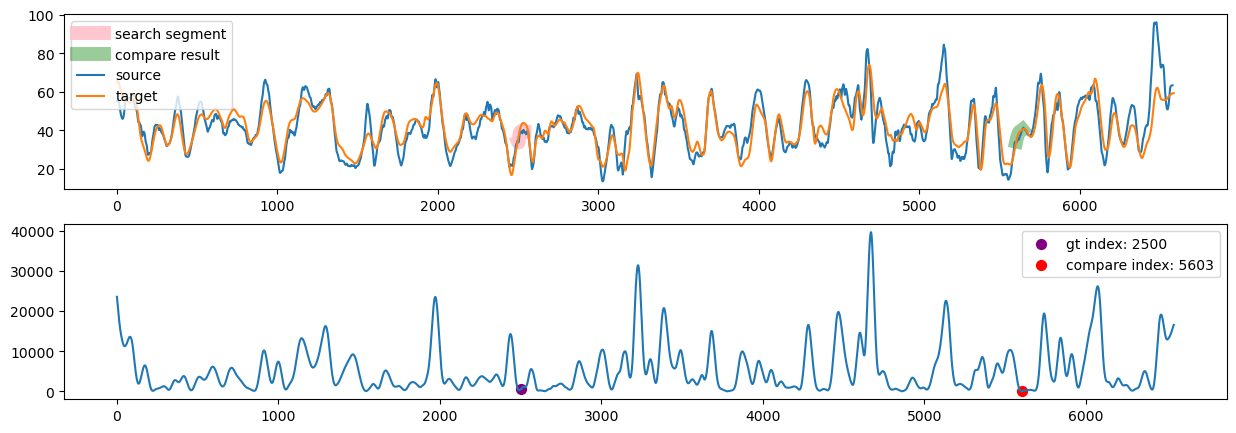

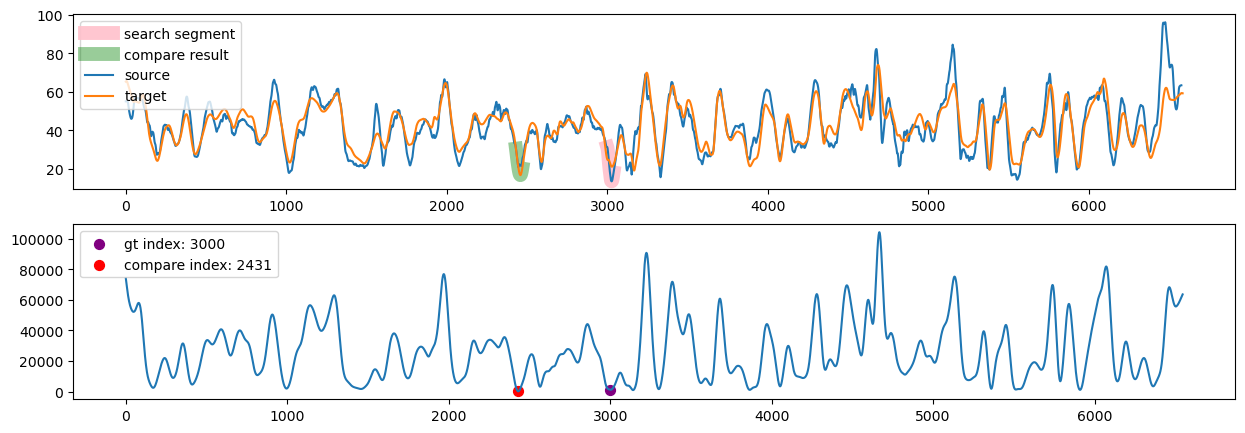

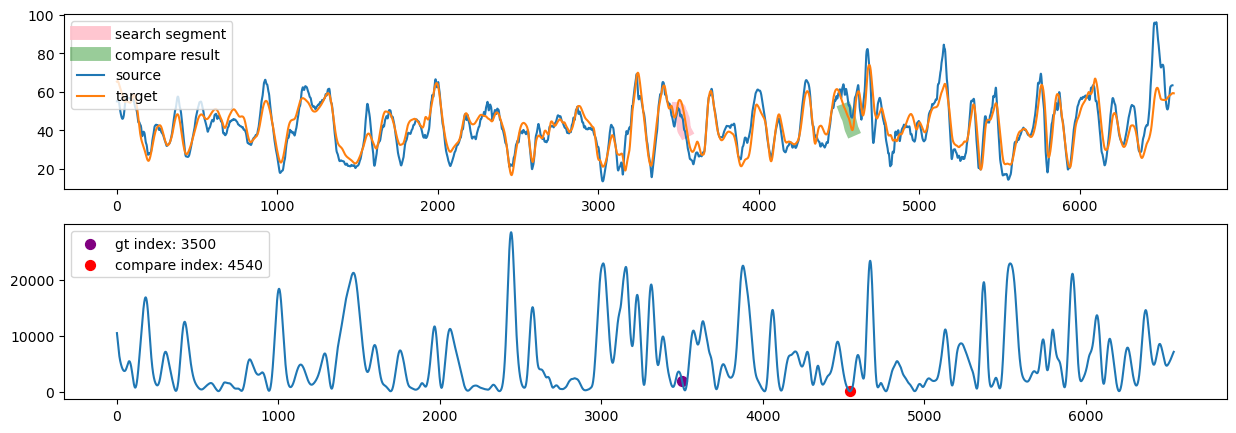

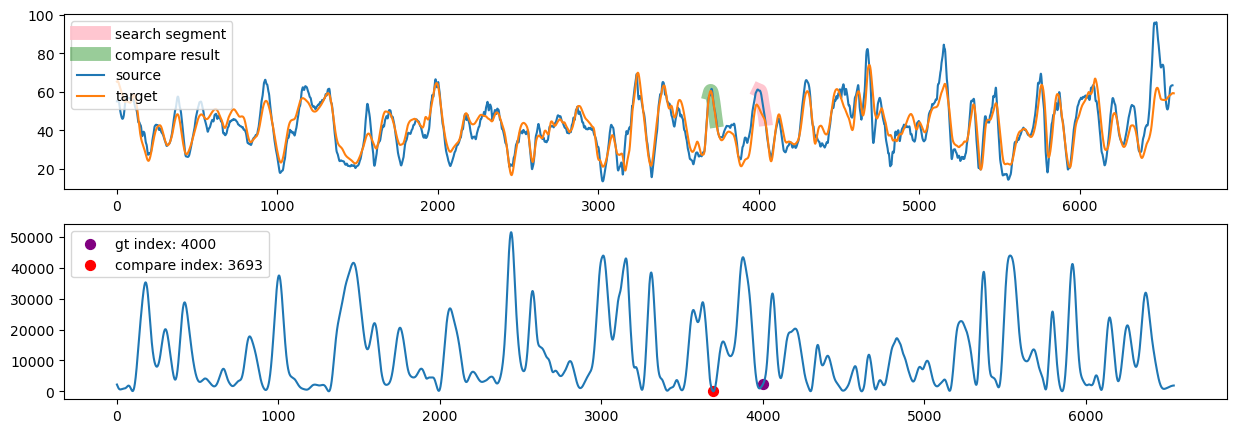

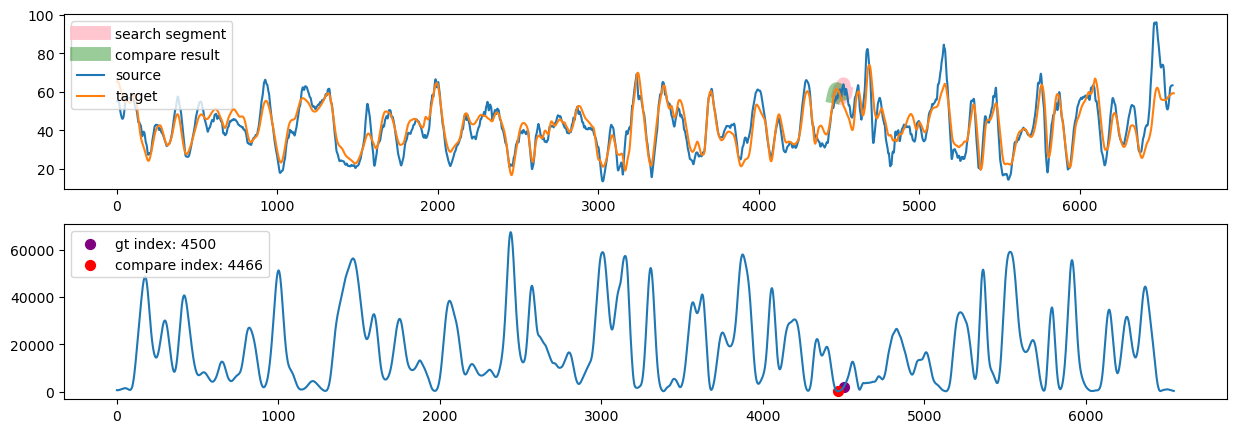

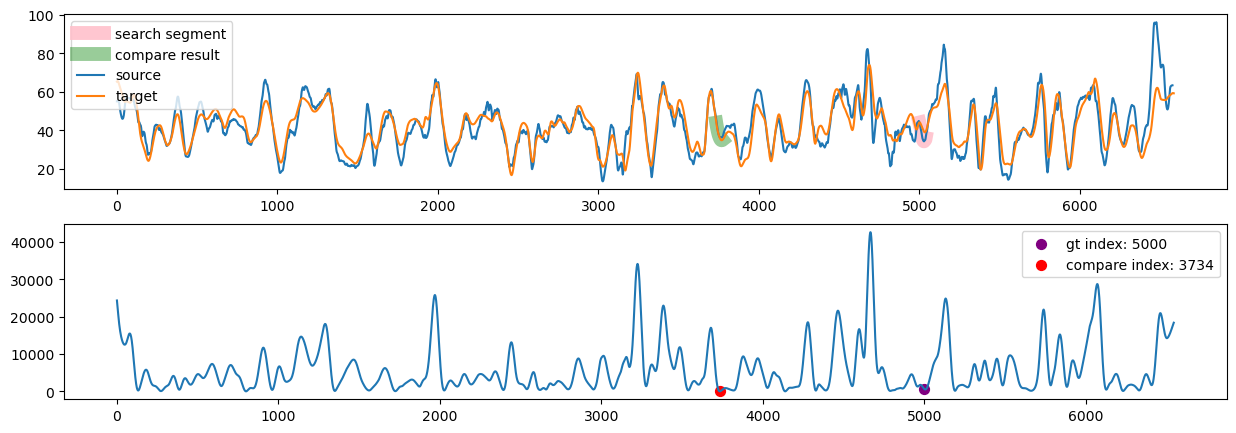

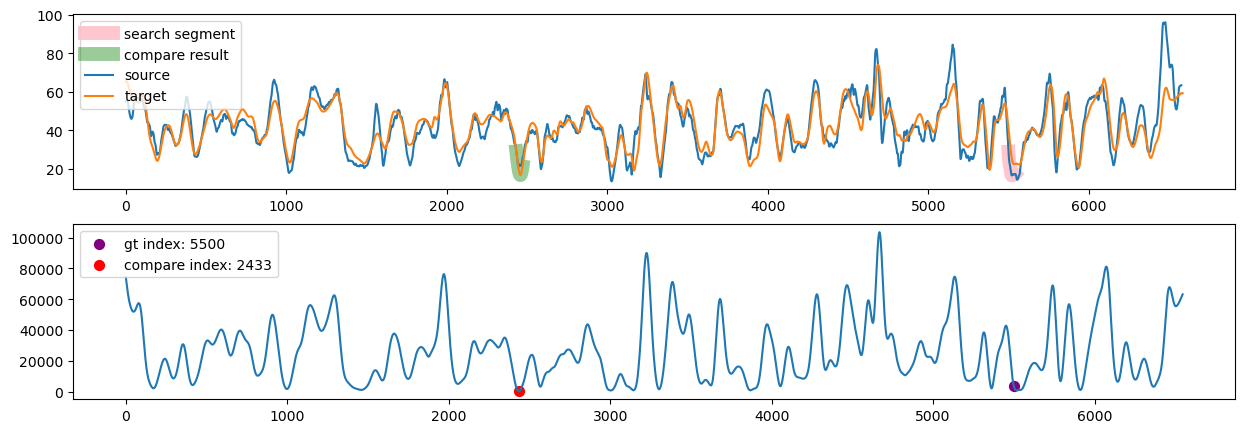

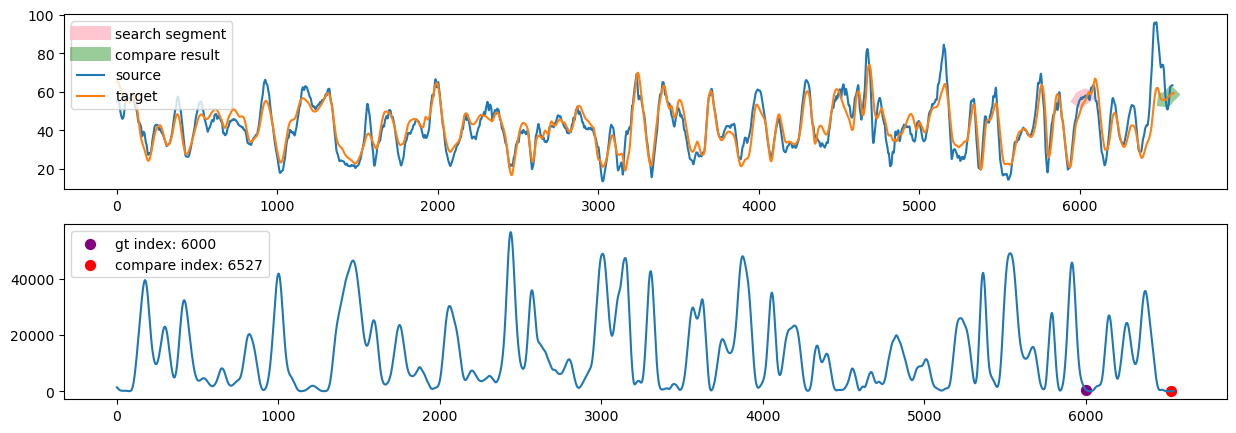

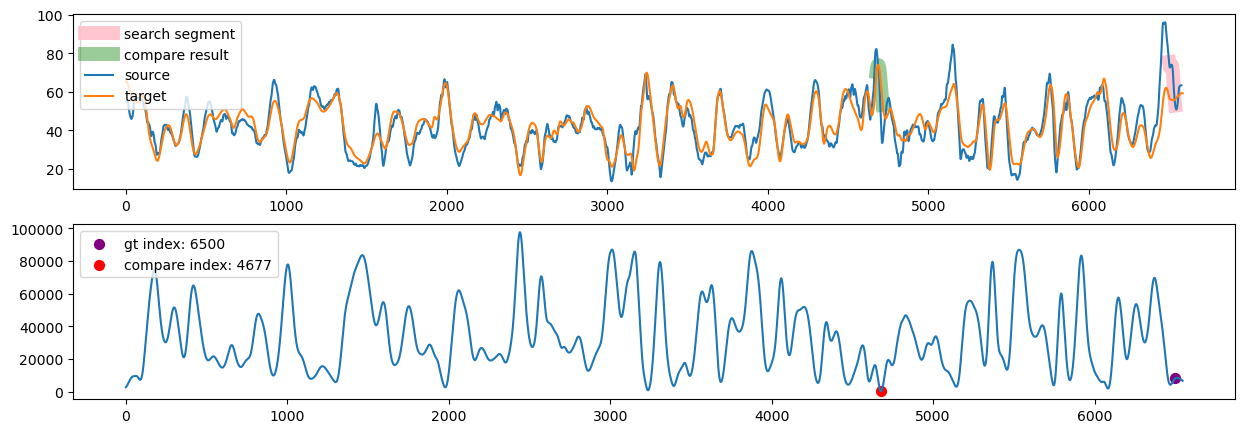

In [10]:
poses = ['./pocket', './front_pocket', './swing']

for i in poses:
    files = os.listdir(i)
    for j in files:
        if j.startswith('.'):
            continue 
        older_path = os.path.join(i, j)
        check(older_path, window_size=40)
    
        break
#     break

In [6]:
# time align

def rename_data(df):
    new_names = ['system_time', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df

def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time

def load_original_data(path):
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = mag_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

def align_data_by_time(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df

def gen_df(df: pd.DataFrame):
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    
    return df

def get_data(folder: str):
    
    source_loc = folder + '/source/'
    target_loc = folder + '/target/'
    
    source = gen_df(load_original_data(source_loc))
    target = gen_df(load_original_data(target_loc))
    
    return source, target